# Scraping Dynamic Web Sites 

- Web scraping (as we have seen so far) works on the principle of navigating HTML content (e.g. with Beautiful Soup). We sometimes interact with these websites through their url. 

#### What if:
- Can't decipher the URL. 
- The html returned from the server is not fully formed. Instead, executable scripts (i.e. JavaScript) construct them on the client machine. We can call them dynamic websites


## Installation

https://selenium-python.readthedocs.io/installation.html


1- Install library,  !pip install selenium

2- <b>Install a Selenium supported WebDriver </b> for your favorite web browser. In what follows, you will be working with Firefox, but Chrome should work as well.

Download the matching asset file from 
- https://github.com/mozilla/geckodriver/releases/ for Firefox, or
- https://sites.google.com/a/chromium.org/chromedriver/downloads for Chrome


<mark>Make sure it’s in your PATH </mark>, e. g., place it in /usr/bin or /usr/local/bin.
Assuming you download the file under ~/Downaloads, following commands should help on the terminal
cd ~/Downloads
mv geckodriver ~/local/bin

Failure to observe this step will give you an error `selenium.common.exceptions.WebDriverException: Message: ‘geckodriver’ executable needs to be in PATH.`


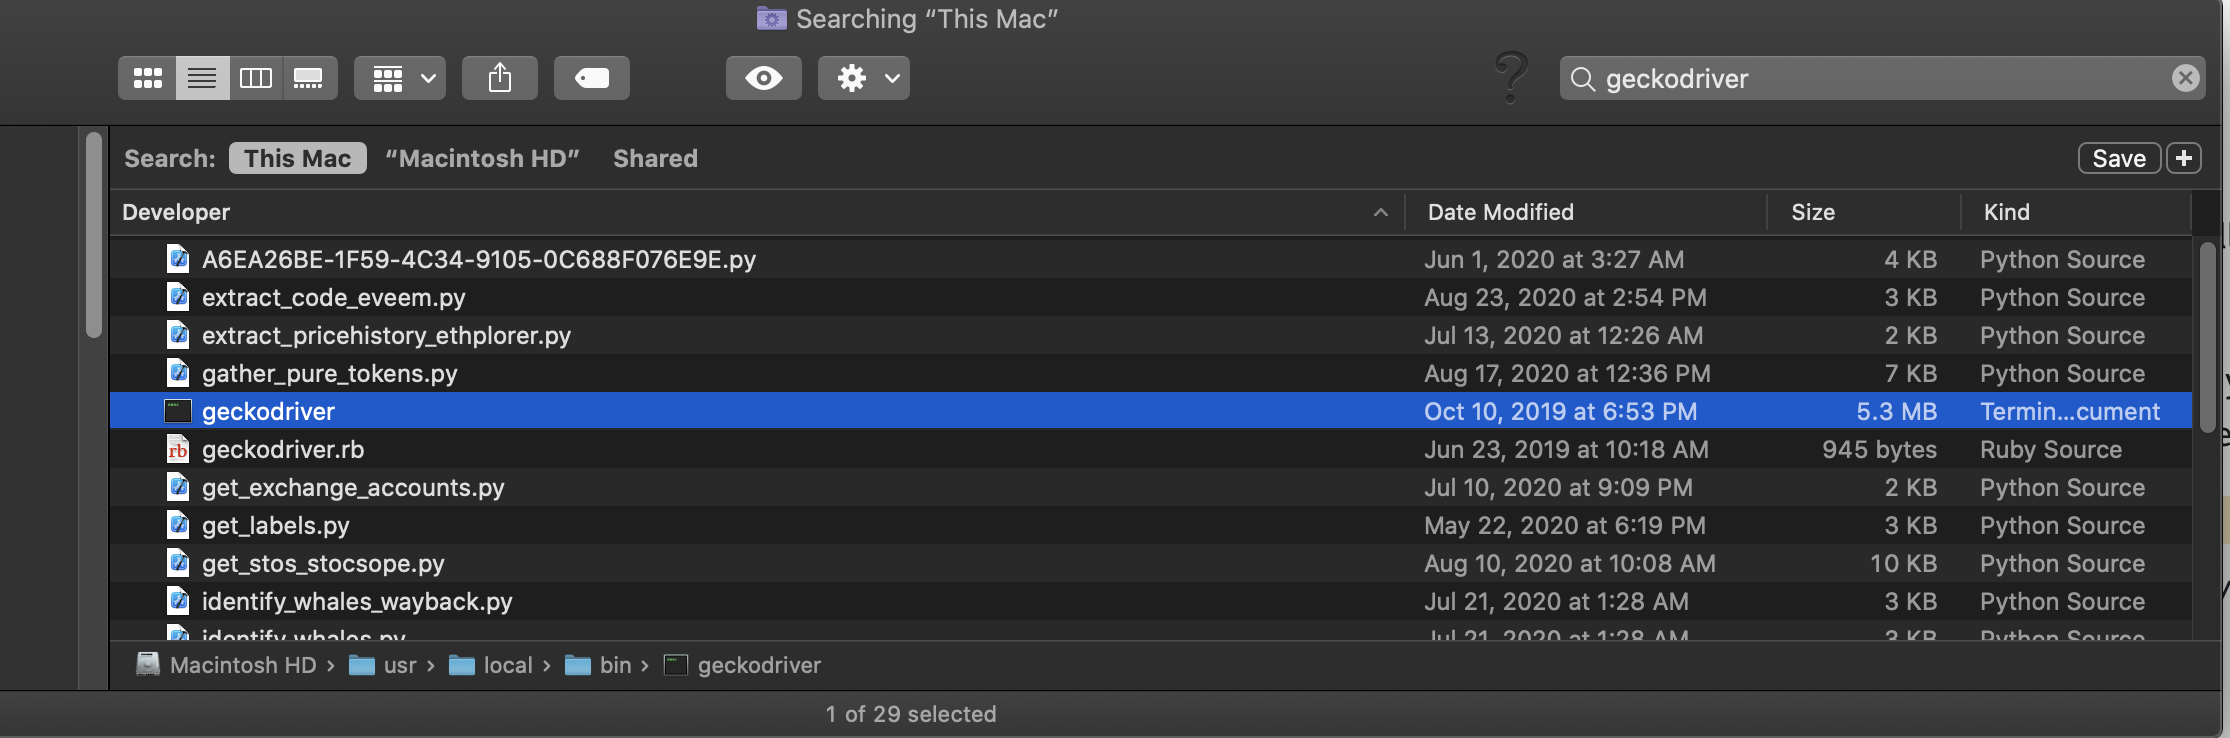


<br>
<br>
<br>
<br>

<div align='center'> <b>Goal:</b> Scrape  <font color='blue'>Schedule Explorer</font> for <i>class details</i> of the MSIS curriculum

 - Setup Connect with Selenium
 
 - Interaction: Fill out dropbox values

 - Get content: Working with links and pop-ups

 - Merge Data

 - Extra: Headless Browsers


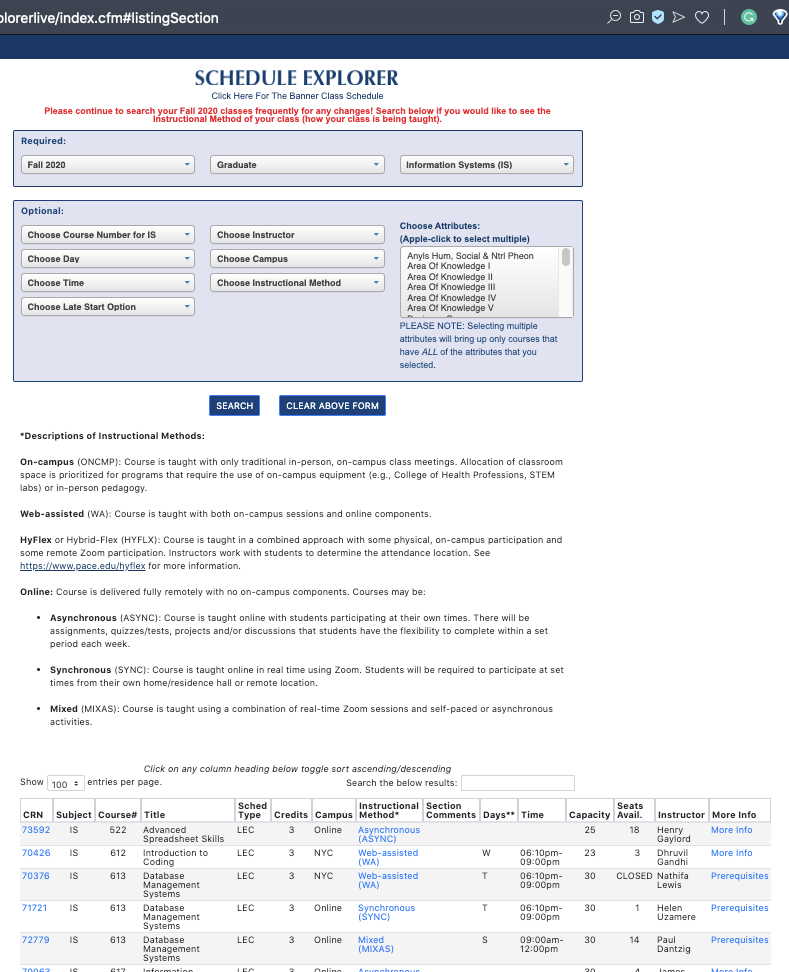

## Setup 

In [51]:
import selenium
import pandas as pd
from bs4 import BeautifulSoup
import time

In [52]:
from selenium.webdriver import Chrome, Firefox

In [53]:
browser=Chrome()

In [54]:
url='https://appsrv.pace.edu/ScheduleExplorerLive/'

In [55]:
browser.get(url)

## Interaction 

In [56]:
from selenium.webdriver.support.ui import Select

In [57]:
term=Select( browser.find_element_by_id('checkterm'))
term.select_by_visible_text('Fall 2020')

In [58]:
level=Select(browser.find_element_by_id('level'))
level.select_by_visible_text('Graduate')

In [59]:
subject=Select(browser.find_element_by_id('subject'))
subjects= [subject.text for subject in subject.options]

In [60]:
IS_text=[subject for subject in subjects if 'IS' in subject][0]
subject.select_by_visible_text(IS_text)
search_button=browser.find_element_by_id('submitbutton')
search_button.click()

In [61]:
## Extra to increase the table size
dd_number=Select(browser.find_element_by_name('mainResultsTable_length'))
dd_number.select_by_value('100')

## Get the content

### 1. Reading and the page and extracting the list

In [66]:
html=browser.page_source
courses=pd.read_html(html)[0]
soup=BeautifulSoup(html,'html.parser')
links=soup.find_all('a',{'href':True})

## I will only get the links for CRN numbers

links_selected=soup.find_all('a',{'data-toggle':'modal'})
crn_links=[link for link in links_selected  if link.next.strip().isnumeric()]

### 2. Browse the links 

<b style='color:red' >Problem: </b> Links do not have <mark>"href"</mark> arguments

We will need to simulate clicking on these links to trigger the java script functions 

Let's write a function that will return one pop up message

In [71]:
def read_crn(crn_link):
    link=browser.find_element_by_partial_link_text(crn_link.text.strip())
    time.sleep(.5)
    link.click()
    popup_content=browser.find_element_by_id('modalBodyContentDiv')
    
    df=pd.read_html(popup_content.get_attribute('innerHTML'))[0].T
    df=pd.read_html(popup_content.get_attribute('innerHTML'))[0].T
    header=df.iloc[0]
    df=df[1:]
    df.columns=header
   
    pop_up_header=browser.find_element_by_class_name('modal-header')
    header_close=pop_up_header.find_element_by_tag_name('Button')
    time.sleep(.5)
    header_close.click()
    return df

In [65]:
dfs=[]
for crn_link in crn_links:
    df=read_crn(crn_link)
    dfs.append(df)

ElementClickInterceptedException: Message: element click intercepted: Element <a href="" data-toggle="modal" data-target="#theModalPopup" onclick="updateModalContent('73592','202070')">...</a> is not clickable at point (39, 219). Other element would receive the click: <b>...</b>
  (Session info: chrome=85.0.4183.121)


In [ ]:
all_is_cours_decs=pd.concat(dfs)

## Combine datasets 

In [40]:
all_is_cours_decs['CRN:']=pd.to_numeric(all_is_cours_decs['CRN:'])

NameError: name 'all_is_cours_decs' is not defined

In [41]:
main_table=pd.read_html(html)[0]

In [42]:
main_table.head()

,CRN,Subject,Course#,Title,Sched Type,Credits,Campus,Instructional Method*,Section Comments,Days**,Time,Capacity,Seats Avail.,Instructor,More Info
0,73592,IS,522,Advanced Spreadsheet Skills,LEC,3,Online,Asynchronous (ASYNC),NaN,NaN,NaN,25,18,Henry Gaylord,More Info
1,70426,IS,612,Introduction to Coding,LEC,3,NYC,Web-assisted (WA),NaN,W,06:10pm-09:00pm,23,03,Dhruvil Gandhi,More Info
2,70376,IS,613,Database Management Systems,LEC,3,NYC,Web-assisted (WA),NaN,T,06:10pm-09:00pm,30,CLOSED,Nathifa Lewis,Prerequisites
3,71721,IS,613,Database Management Systems,LEC,3,Online,Synchronous (SYNC),NaN,T,06:10pm-09:00pm,30,01,Helen Uzamere,Prerequisites
4,72779,IS,613,Database Management Systems,LEC,3,Online,Mixed (MIXAS),NaN,S,09:00am-12:00pm,30,14,Paul Dantzig,Prerequisites


In [43]:
all_is_cours_decs=all_is_cours_decs.rename({'CRN:':'CRN'}, axis='columns')
all_is_cours_decs.head()

NameError: name 'all_is_cours_decs' is not defined

In [44]:
combined_IS=main_table.merge(all_is_cours_decs, how='left', on='CRN')

NameError: name 'all_is_cours_decs' is not defined

In [45]:
combined_IS.columns

NameError: name 'combined_IS' is not defined

## Headless Browser

A headless browser is a web browser without a graphical user interface.

Run without UI so they are faster


In [46]:
from selenium.webdriver.firefox.options import Options
opts = Options()
opts.set_headless()
assert opts.headless  # Operating in headless mode
browser2 = Firefox(options=opts)

<ipython-input-46-adcbc449250b>:3: DeprecationWarning: use setter for headless property instead of set_headless
  opts.set_headless()


SessionNotCreatedException: Message: Unable to find a matching set of capabilities


In [ ]:
browser2.get(url)

In [47]:
term=Select( browser2.find_element_by_id('checkterm'))
term.select_by_visible_text('Fall 2020')
level=Select(browser2.find_element_by_id('level'))
level.select_by_visible_text('Graduate')
subject=Select(browser2.find_element_by_id('subject'))
subjects= [subject.text for subject in subject.options]

NameError: name 'browser2' is not defined

In [48]:
IS_text=[subject for subject in subjects if 'IS' in subject][0]
subject.select_by_visible_text(IS_text)
search_button=browser2.find_element_by_id('submitbutton')
search_button.click()

StaleElementReferenceException: Message: stale element reference: element is not attached to the page document
  (Session info: chrome=85.0.4183.121)


In [49]:
def read_crn(crn_link):
    link=browser2.find_element_by_partial_link_text(crn_link.text.strip())
    time.sleep(.3)  ### Since headless process is f
    link.click()
    popup_content=browser2.find_element_by_id('modalBodyContentDiv')

    df=pd.read_html(popup_content.get_attribute('innerHTML'))[0].T
    df=pd.read_html(popup_content.get_attribute('innerHTML'))[0].T
    header=df.iloc[0]
    df=df[1:]
    df.columns=header
    #dfs.append(df)
    pop_up_header=browser2.find_element_by_class_name('modal-header')
    header_close=pop_up_header.find_element_by_tag_name('Button')
    time.sleep(.3)  ## more on explicit waits (wait until loads) https://selenium-python.readthedocs.io/waits.html#
    header_close.click()
    browser2.implicitly_wait(5)
    return df

In [50]:
dfs=[]
for i, crn_link in enumerate(crn_links):
    #print(i)
    df=read_crn(crn_link)
    dfs.append(df)
    

NameError: name 'browser2' is not defined